In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
import jax.numpy as jnp
from jax import random,vmap, grad
from jax.lax import while_loop
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy


matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/cosmo/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [2]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,5).reshape(-1, 1)
ninit = 4
ndim = 1
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)

f_mean = 0.33
f_std = 0.2
f = lambda x: -0.5*(x-f_mean)**2 / f_std**2  

train_y = f(train_x)
test_x =  np.linspace(0,1,100).reshape(-1, 1)
test_y = f(test_x)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=1)
start = time.time()
mu, var = gp.posterior(test_x,single=True)

print(f"predicting took {time.time() - start:.4f}s\n")

Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:00<00:00, 1234.78it/s, 7 steps of size 6.49e-01. acc. prob=0.91]



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     16.38     29.64      5.19      0.12     44.32    229.60      1.01
        kernel_length[0]      0.59      0.20      0.60      0.25      0.89    225.91      1.01
            kernel_tausq      1.71      3.95      0.52      0.01      3.51    364.72      1.00
              kernel_var     13.02      8.43     11.40      1.31     24.41    466.18      1.00

Number of divergences: 0

MCMC elapsed time: 1.94s
predicting took 0.1794s



[Text(0.5, 0, 'lengthscale'), Text(0, 0.5, 'outputscale')]

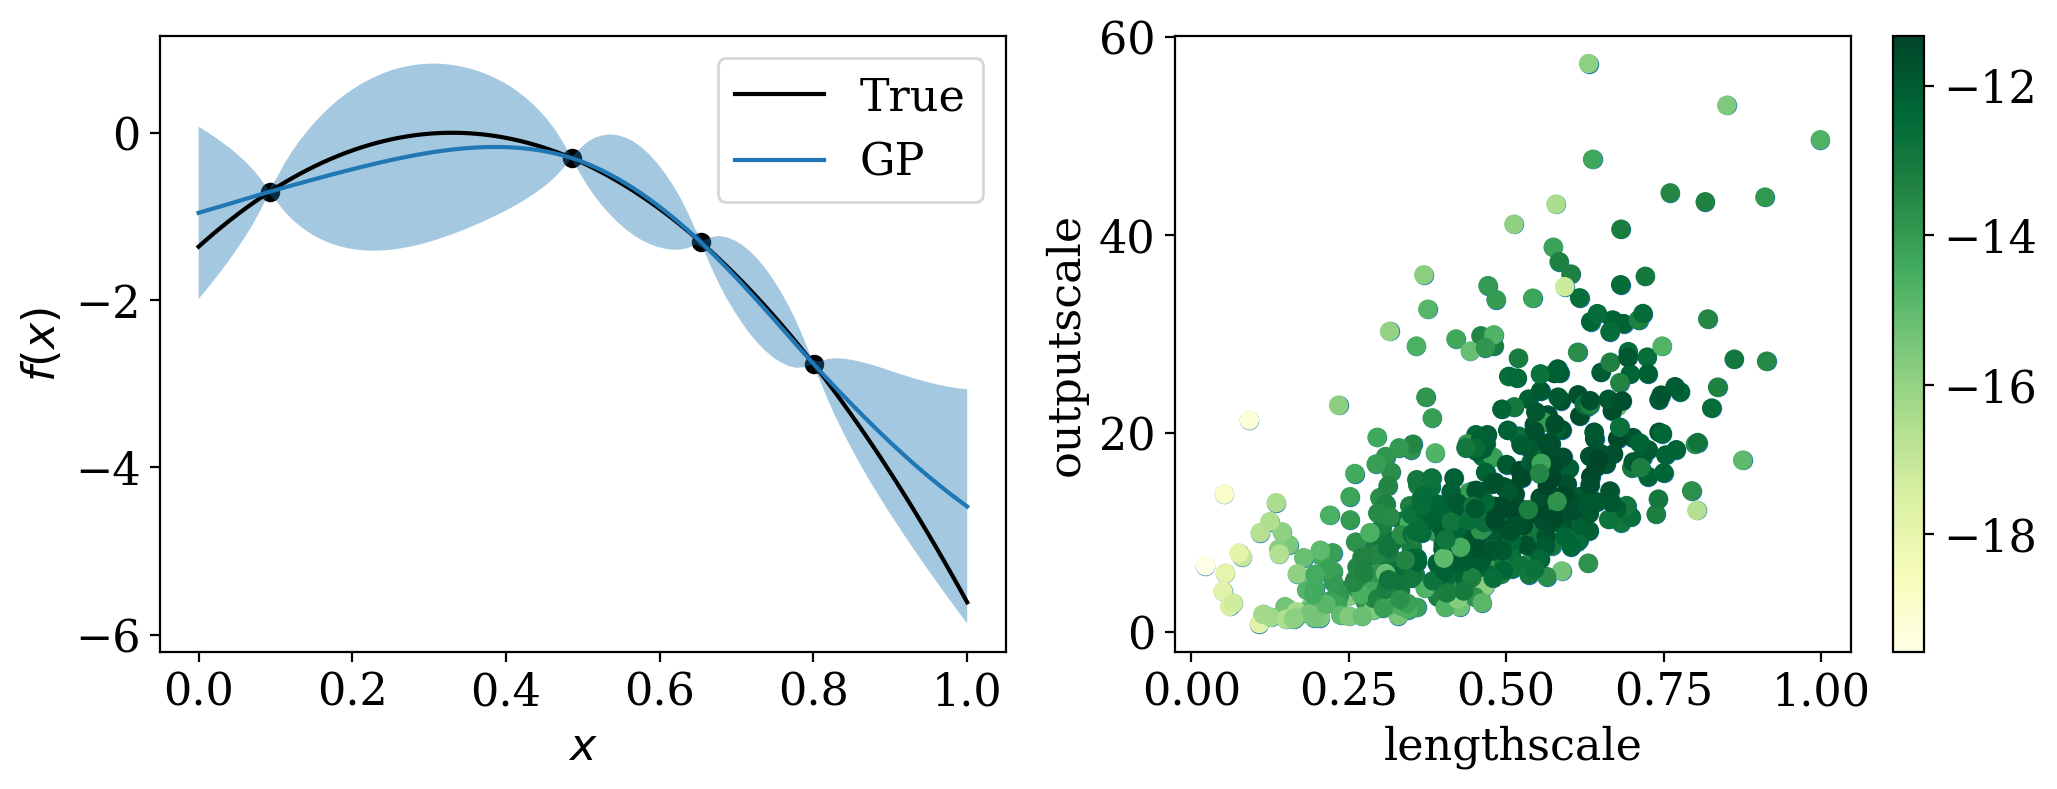

In [21]:
std = jnp.sqrt(var)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(test_x,test_y,label='True',color='k')
ax1.scatter(train_x,train_y,color='k')
ax1.plot(test_x,mu,label='GP')
ax1.fill_between(test_x[:,0],mu-1.96*std,mu+1.96*std,alpha=0.4)
ax1.set(xlabel=r'$x$',ylabel=r'$f(x)$')
ax1.legend()



colors = matplotlib.colormaps['YlGn']

l = np.array(gp.samples["kernel_length"].squeeze(-1))
o = np.array(gp.samples["kernel_var"])
lp = -np.array(gp.samples["minus_log_prob"])
lp_min, lp_max = np.min(lp), np.max(lp)
cols = np.linspace(lp_min,lp_max,len(lp))
cols = (cols - lp_min)/(lp_max - lp_min)


ax2.scatter(l,o)

sc = ax2.scatter(l,o,c = lp, vmin = lp_min, vmax=lp_max,cmap= colors)
fig.colorbar(sc,ax=ax2)

ax2.set(xlabel=r'lengthscale',ylabel=r'outputscale')

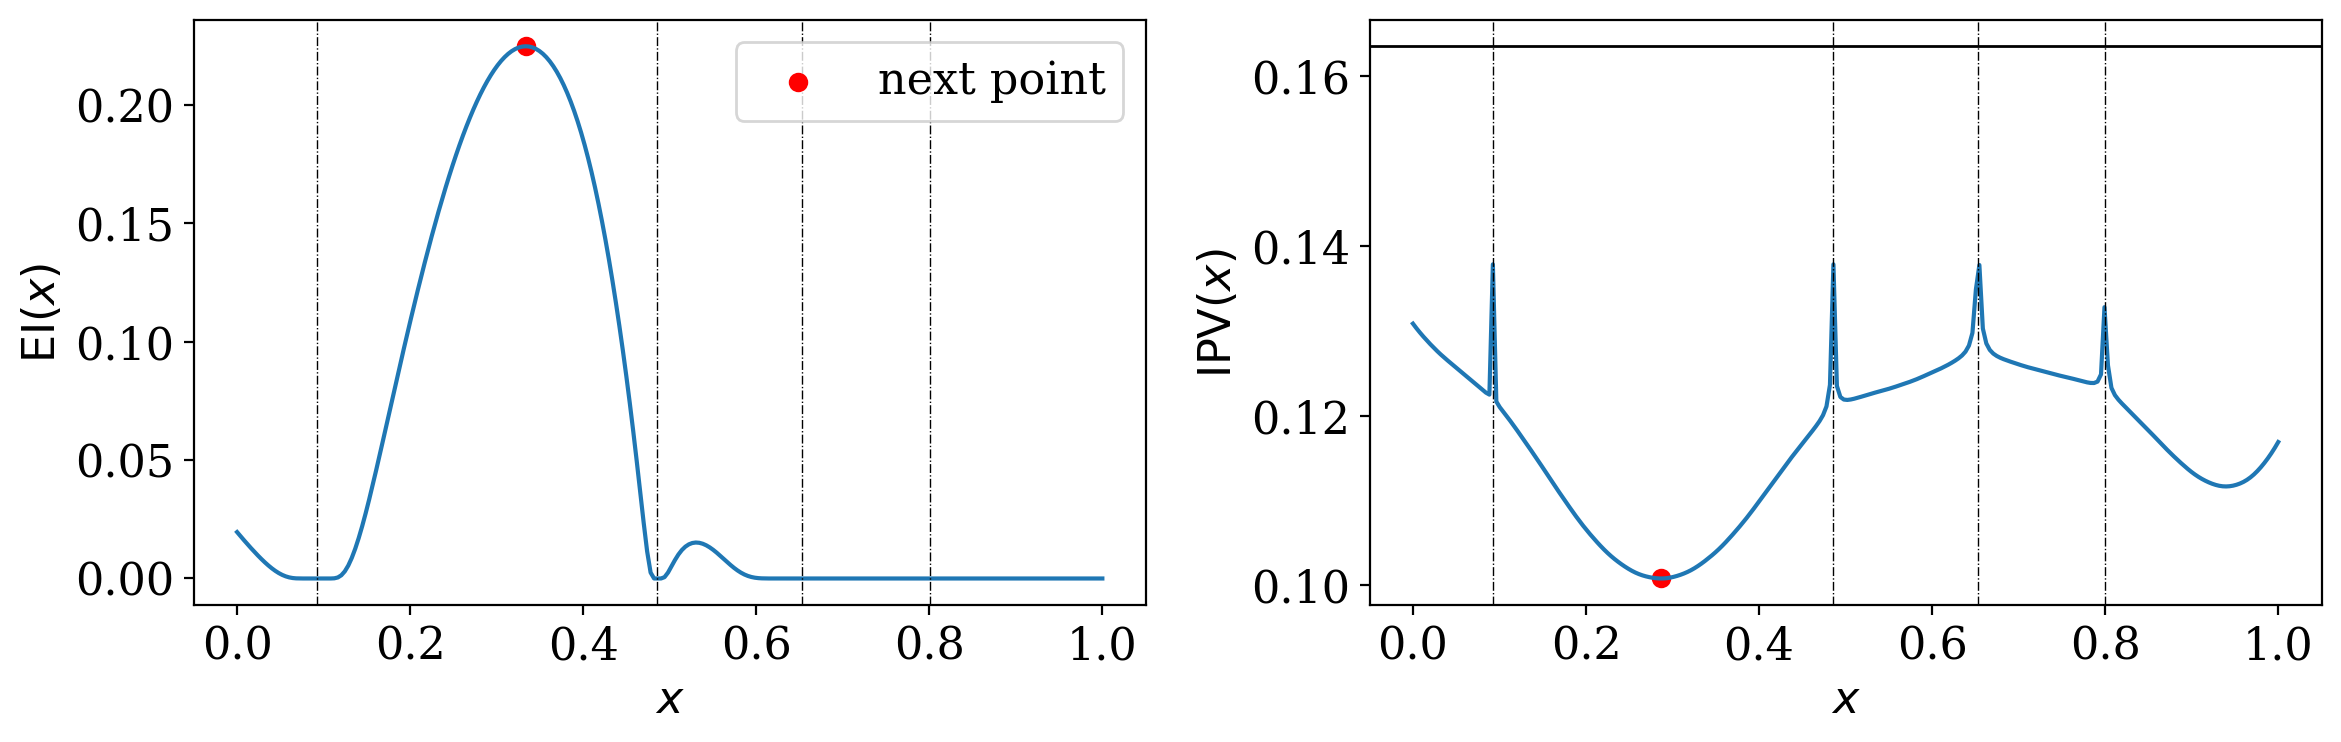

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
acq_func = EI(gp,best_f=gp.train_y.max(),zeta=0.1)
acq_x =  np.linspace(0,1,250).reshape(-1, 1)
acq_vals = -vmap(acq_func)(acq_x)

grad_fn = grad(acq_func)

results = optim_scipy_bh(acq_func,x0=np.random.uniform(),stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': [(0,1)] })
next_x = results.x
next_val = -results.fun

ax1.plot(acq_x,acq_vals)
ax1.scatter(next_x,next_val,color='r',label=r'next point')
ax1.set(xlabel=r'$x$',ylabel=r'$\mathrm{EI}(x)$')
ax1.legend()

mc_points = jnp.linspace(0,1,32).reshape(-1,1)
_, pre_var = gp.posterior(mc_points,unstandardize=False)
pre_var = pre_var.mean()
acq_func = IPV(gp,mc_points)

acq_vals = vmap(acq_func)(acq_x)

grad_fn = grad(acq_func)

results = optim_scipy_bh(acq_func,x0=np.random.uniform(),stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': [(0,1)] })
next_x = results.x
next_val = results.fun

ax2.plot(acq_x,acq_vals)
ax2.scatter(next_x,next_val,color='r',label=r'next point')

ax2.set(xlabel=r'$x$',ylabel=r'$\mathrm{IPV}(x)$')

for axes in [ax1,ax2]:
    for pt in train_x:
        axes.axvline(pt,color='k',ls='-.',lw=0.5)
ax2.axhline(pre_var,color='k',lw=1)

fig.tight_layout()

In [23]:
from nested_sampler import nested_sampling_jaxns

samples, logz_dict = nested_sampling_jaxns(gp,ndim=1,dlogz=0.01)

Nested Sampling took 1.0965s
jaxns made 5778 likelihood evaluations
(195, 1)


(1000, 1)
LogZ logz_mean: -0.9419, dlogz: 0.1419, 


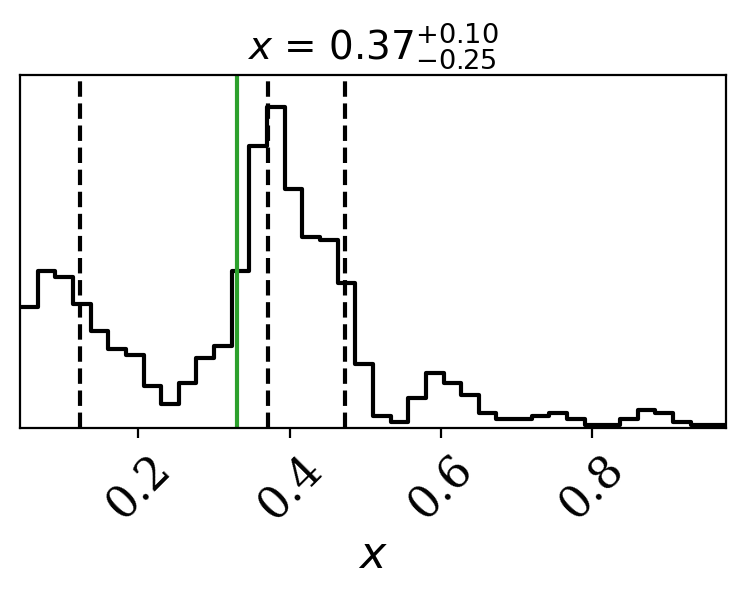

In [25]:
print(samples.shape)

print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

fig = plt.figure(figsize=(6,3))

fig = corner.corner(samples,labels=[
        r"$x$",],
    quantiles=[0.16, 0.5,0.84],
    show_titles=True,
    title_kwargs={"fontsize": 14},
    fig=fig,hist_bin_factor=2,smooth1d=1.,truth=(0.5,),truth_color='red'
)

corner.overplot_lines(fig,[f_mean],color='C2')


In [26]:
from nested_sampler import nested_sampling_Dy

samples, logz_dict = nested_sampling_Dy(gp,maxcall=8000,dlogz=0.1,ndim=1)

Nested Sampling took 8.2262s
Log Z evaluated using (1930,) points
Dynesty made 8515 function calls


LogZ mean: -0.8168, upper: -0.4622, lower: -1.1461, dlogz sampler: 0.0360, 
LogZ True = -0.7417


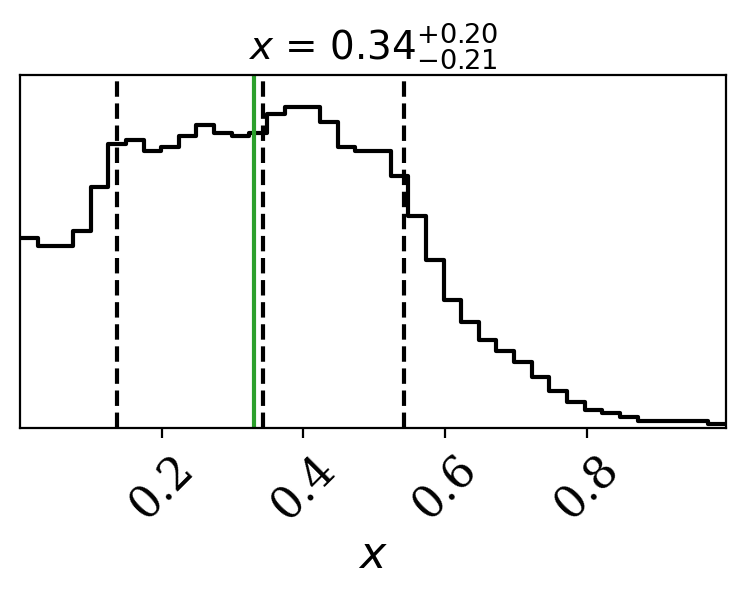

In [27]:
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

x_grid = np.linspace(0,1,500)
logz_true = np.log(np.trapz(np.exp(f(x_grid)),x_grid))
print(f"LogZ True = {logz_true:.4f}")


fig = plt.figure(figsize=(6,3))

fig = corner.corner(samples,labels=[
        r"$x$",],
    quantiles=[0.16, 0.5,0.84],
    show_titles=True,
    title_kwargs={"fontsize": 14},
    fig=fig,hist_bin_factor=2,smooth1d=1.,truth=(0.5,),truth_color='red'
)

corner.overplot_lines(fig,[f_mean],color='C2')


### 2D Example

(15, 2) (15, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:00<00:00, 1457.06it/s, 7 steps of size 5.19e-01. acc. prob=0.94]


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]      2.84      2.46      2.10      0.35      6.67     19.20      1.01
_kernel_inv_length_sq[1]      2.53      2.71      1.64      0.34      6.63     33.60      0.98
        kernel_length[0]      0.82      0.23      0.78      0.55      1.11     32.69      0.97
        kernel_length[1]      0.91      0.24      0.91      0.56      1.19     24.52      1.00
            kernel_tausq      1.30      1.23      0.76      0.11      3.12     31.06      0.97
              kernel_var     32.35     15.09     32.38     11.68     55.38     81.66      0.98

Number of divergences: 0

MCMC elapsed time: 0.78s


Text(0, 0.5, '$x_2$')

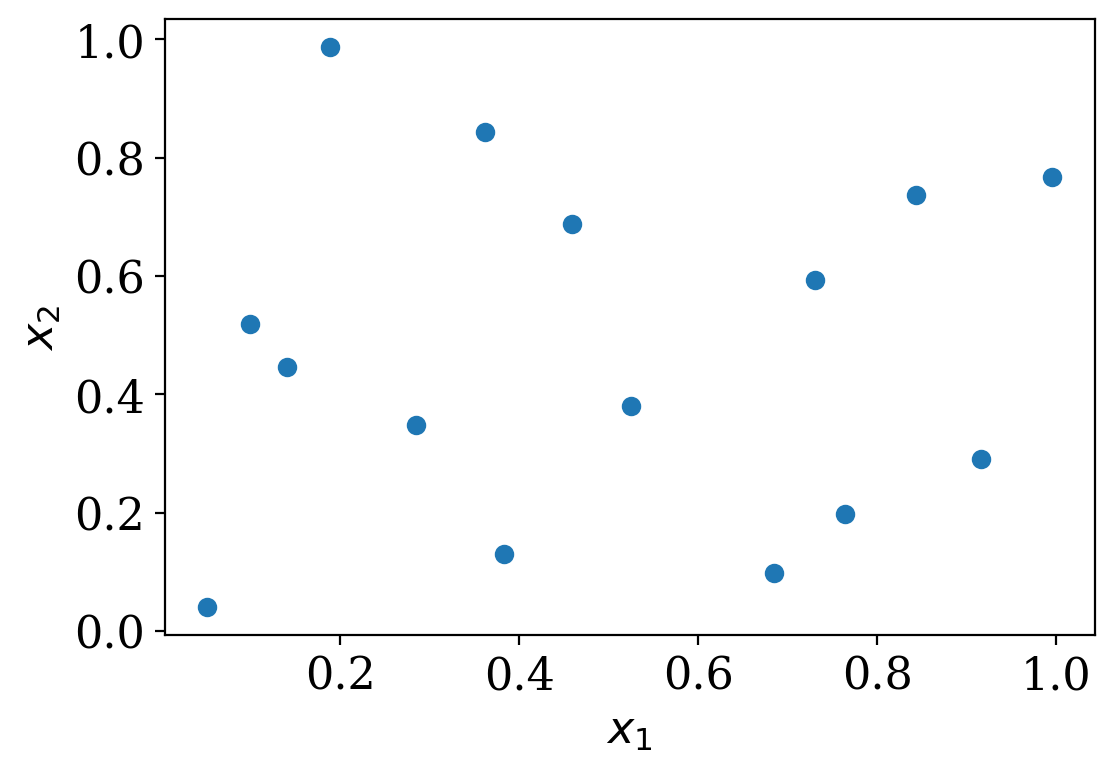

In [28]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 15
ndim = 2
train_x = qmc.Sobol(ndim, scramble=True).random(32)[:ninit]
f_mean = np.array([0.4,0.6])
f_std = 0.1
f = lambda x: -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16)

plt.figure(figsize=(6,4))
plt.scatter(train_x[:,0],train_x[:,1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

In [29]:
from nested_sampler import nested_sampling_Dy

samples, logz_dict = nested_sampling_Dy(gp,maxcall=10000,dlogz=0.1,ndim=2)

Nested Sampling took 10.1934s
Log Z evaluated using (2056,) points
Dynesty made 10534 function calls


(2056, 2)
LogZ mean: -2.8451, upper: -2.7419, lower: -2.9436, dlogz sampler: 0.1507, 


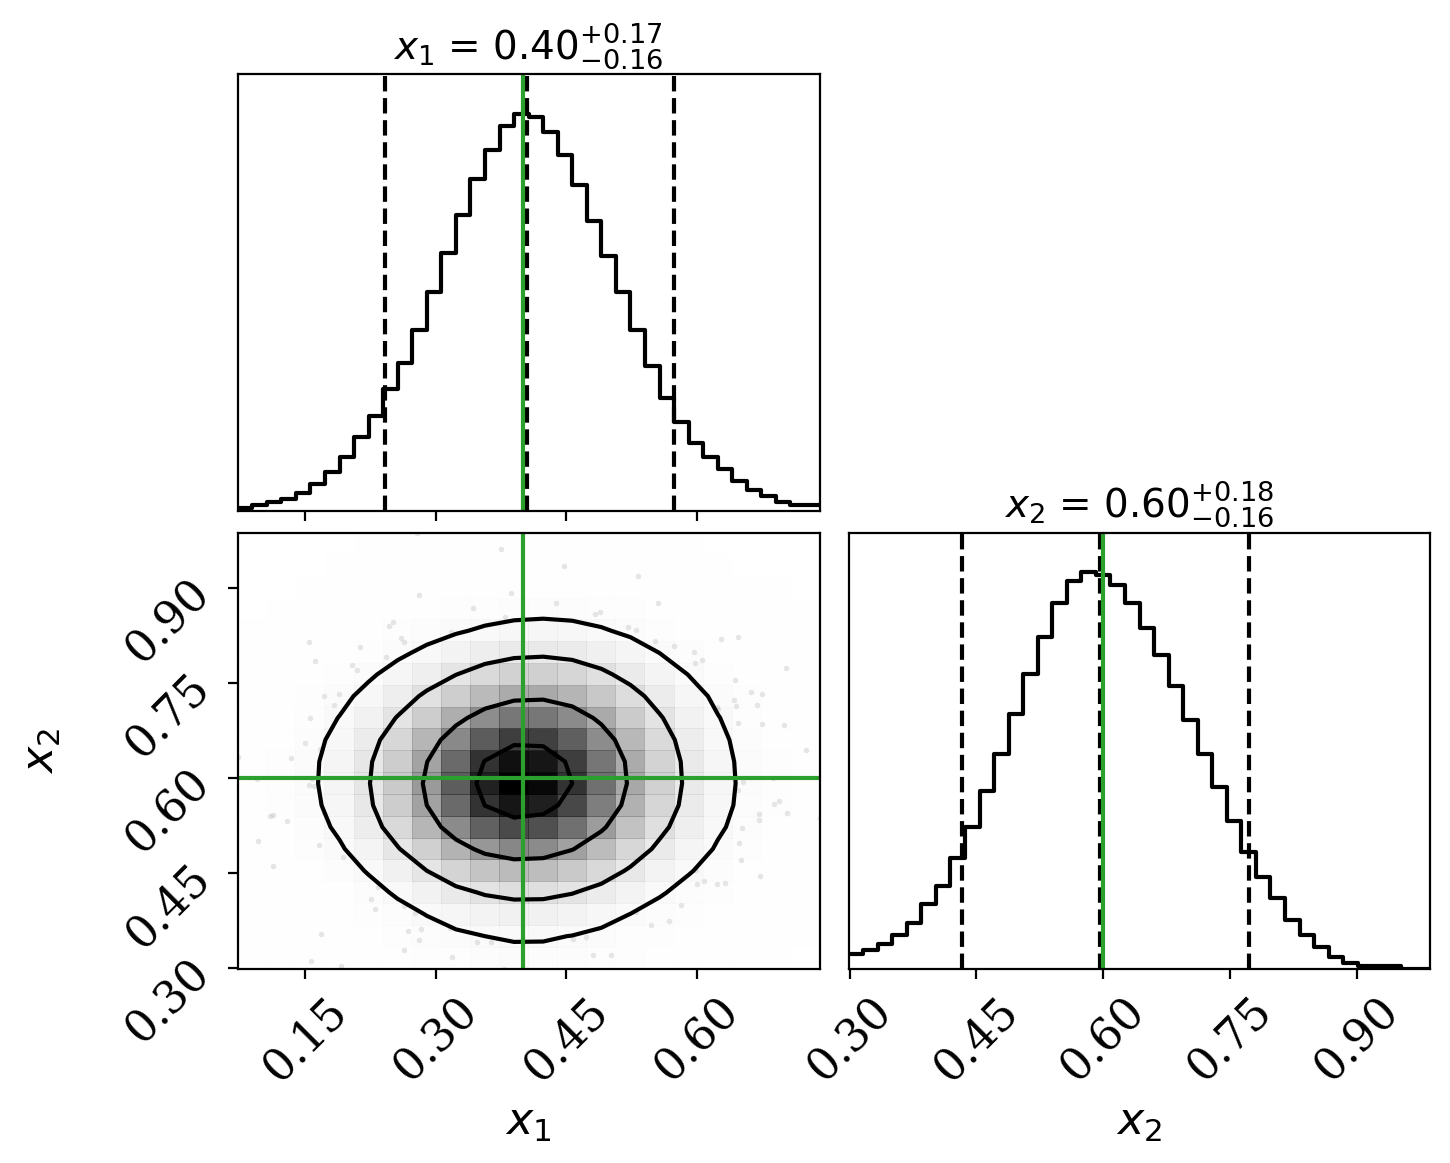

In [30]:
# print(logz_dict)
print(samples.shape)

print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

x_grid = np.linspace(0,1,500)
# logz_true = np.log(np.trapz(np.exp(f(x_grid)),x_grid))
# print(f"LogZ True = {logz_true:.4f}")

fig = plt.figure(figsize=(8,6))

fig = corner.corner(samples,labels=[
        r"$x_1$",r"$x_2$"],
    quantiles=[0.05, 0.5,0.95], # [0.16, 0.5,0.84]
    show_titles=True,
    title_kwargs={"fontsize": 14},
    fig=fig,hist_bin_factor=2,smooth1d=2.,smooth=2.,truth=list[f_mean],truth_color='r'
)

corner.overplot_lines(fig,f_mean,color='C2')


In [31]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=2,dlogz=0.01)

Nested Sampling took 1.4157s
jaxns made 16500 likelihood evaluations
(480, 2)


(2000, 2)
LogZ logz_mean: -2.5226, dlogz: 0.1985, 


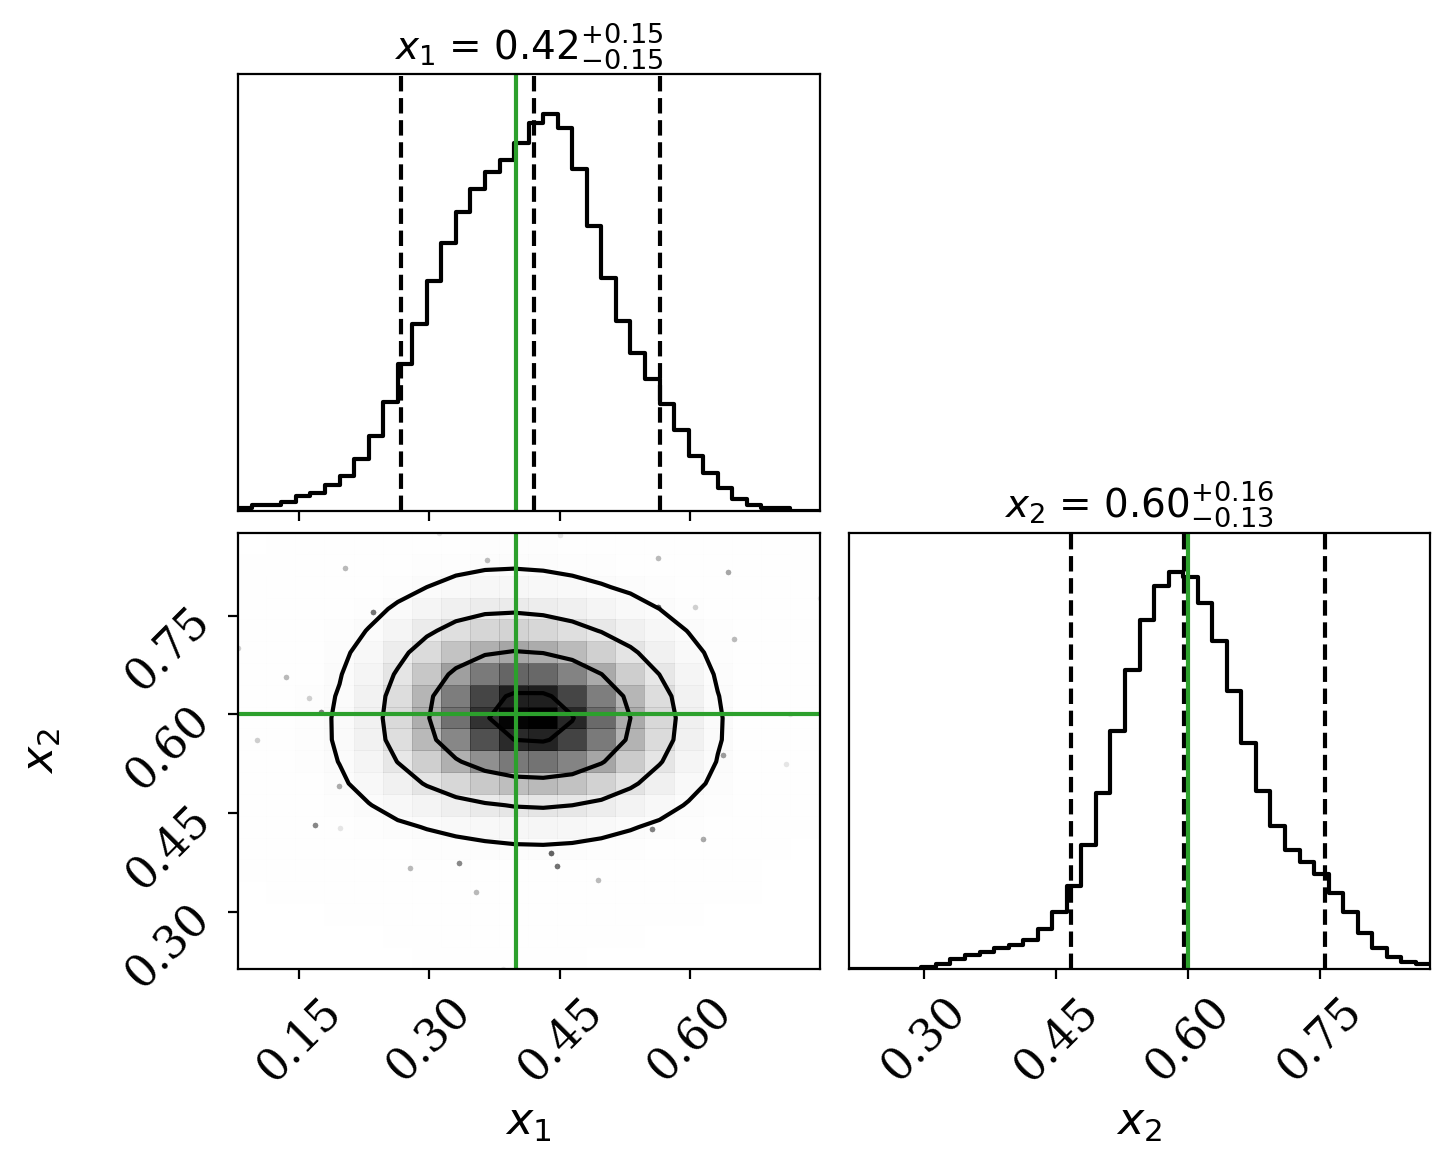

In [32]:
print(samples.shape)

print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

fig = plt.figure(figsize=(8,6))

fig = corner.corner(samples,labels=[
        r"$x_1$",r"$x_2$"],
    quantiles=[0.05, 0.5,0.95], # [0.16, 0.5,0.84]
    show_titles=True,
    title_kwargs={"fontsize": 14},
    fig=fig,hist_bin_factor=2,smooth1d=2.,smooth=2.,truth=list[f_mean],truth_color='r'
)

corner.overplot_lines(fig,f_mean,color='C2')

### 4D Example

[[0.03590944 0.0065594  0.01258754 0.00376176]
 [0.0065594  0.02280095 0.00412191 0.00900116]
 [0.01258754 0.00412191 0.038769   0.00403691]
 [0.00376176 0.00900116 0.00403691 0.02294415]]
(64, 4) (64, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 751.42it/s, 3 steps of size 5.33e-01. acc. prob=0.93]



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]      1.65      1.48      1.06      0.31      4.32     30.94      0.97
_kernel_inv_length_sq[1]      9.27     11.91      3.93      1.47     20.13     25.14      1.00
_kernel_inv_length_sq[2]      0.51      0.49      0.37      0.04      0.96     30.08      0.97
_kernel_inv_length_sq[3]      7.00      7.63      3.44      0.70     15.84     30.57      1.01
        kernel_length[0]      0.34      0.06      0.34      0.25      0.43     20.76      1.11
        kernel_length[1]      0.15      0.02      0.15      0.12      0.17     20.68      0.98
        kernel_length[2]      0.67      0.28      0.64      0.32      1.20     31.70      0.97
        kernel_length[3]      0.18      0.04      0.17      0.12      0.21     30.24      0.97
            kernel_tausq     11.20      7.83      9.50      0.97     20.71     48.44      0.97
              kernel_var      0.97      0.26     

Text(0, 0.5, '$x_4$')

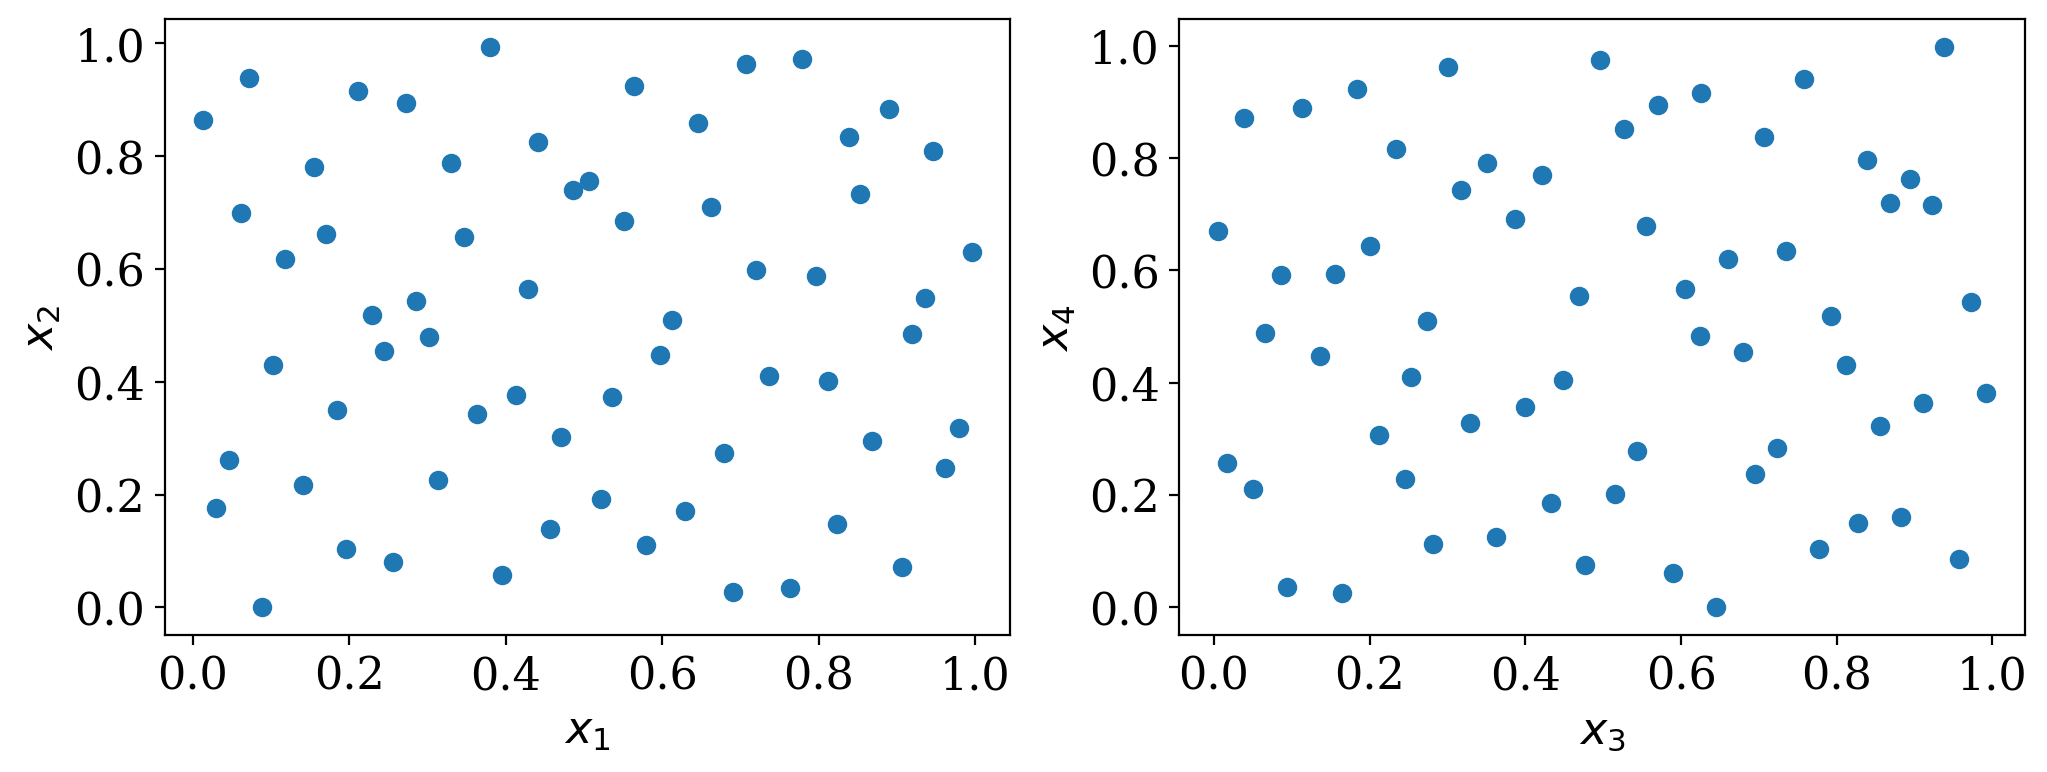

In [3]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 64
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = np.array([0.41,0.63,0.58,0.45])
cov1 = 0.1*np.eye(ndim) + 0.2*np.random.uniform(0.,0.5,(ndim,ndim))
cov = 0.1*(cov1 + np.transpose(cov1))
print(cov)

from scipy.stats import multivariate_normal

mnorm =  multivariate_normal(mean = f_mean,cov = cov)

f = lambda x: mnorm.pdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(train_x[:,0],train_x[:,1])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax2.scatter(train_x[:,2],train_x[:,3])
ax2.set_xlabel(r'$x_3$')
ax2.set_ylabel(r'$x_4$')

In [4]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=2000,difficult_model=False)

Nested Sampling took 3.1019s
jaxns made 68975 likelihood evaluations
(6120, 4)


(8000, 4)
LogZ logz_mean: 9.4826, dlogz: 0.3010, 


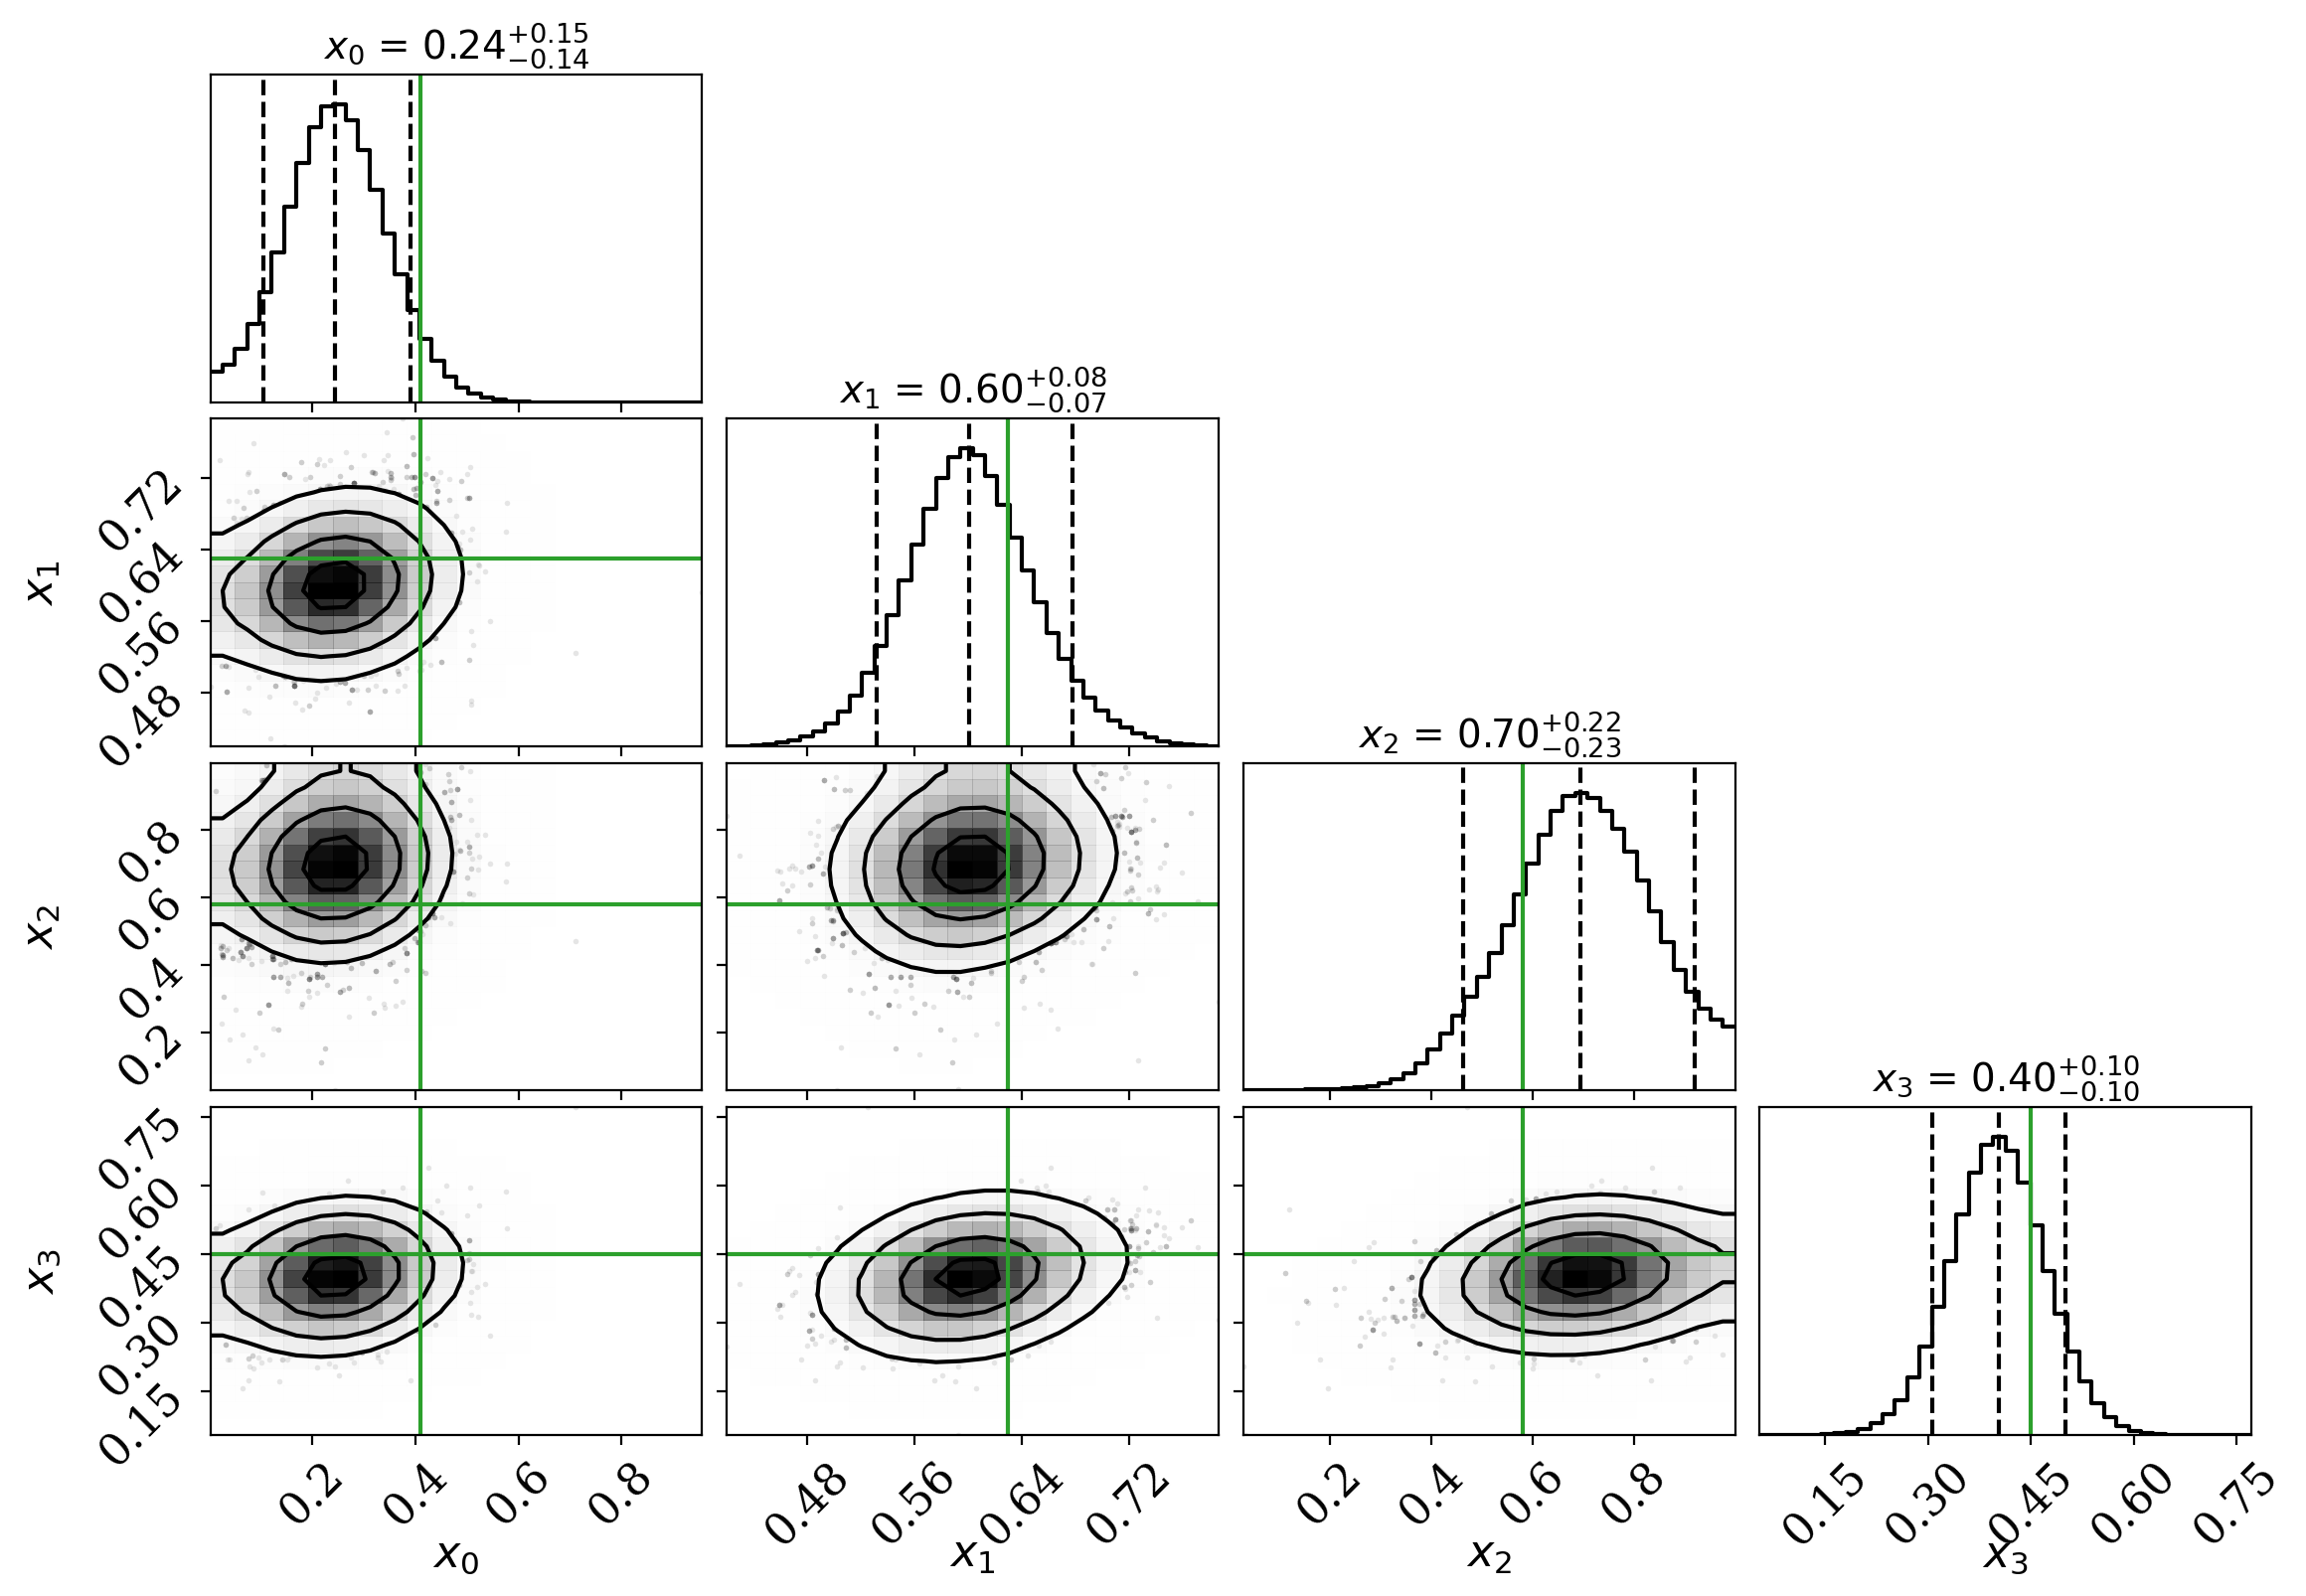

In [5]:
print(samples.shape)

print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))
fig = plt.figure(figsize=(12,8))

fig = corner.corner(samples,labels=["$x_{0}$".format(i) for i in range(ndim)],
    quantiles=[0.05, 0.5,0.95], # [0.16, 0.5,0.84]
    show_titles=True,
    title_kwargs={"fontsize": 14},
    fig=fig,hist_bin_factor=2.,smooth1d=2.,smooth=2.,truth=list[f_mean],truth_color='r'
)

corner.overplot_lines(fig,f_mean,color='C2')

In [9]:
samples, logz_dict = nested_sampling_Dy(gp,ndim=ndim,dlogz=0.01,boost_maxcall=3,maxcall=50000)

Nested Sampling took 114.7844s
Log Z evaluated using (16591,) points
Dynesty made 43031 function calls


(16591, 4)
LogZ mean: 18.2220, upper: 19.6946, lower: 16.8853, dlogz sampler: 0.0733, 


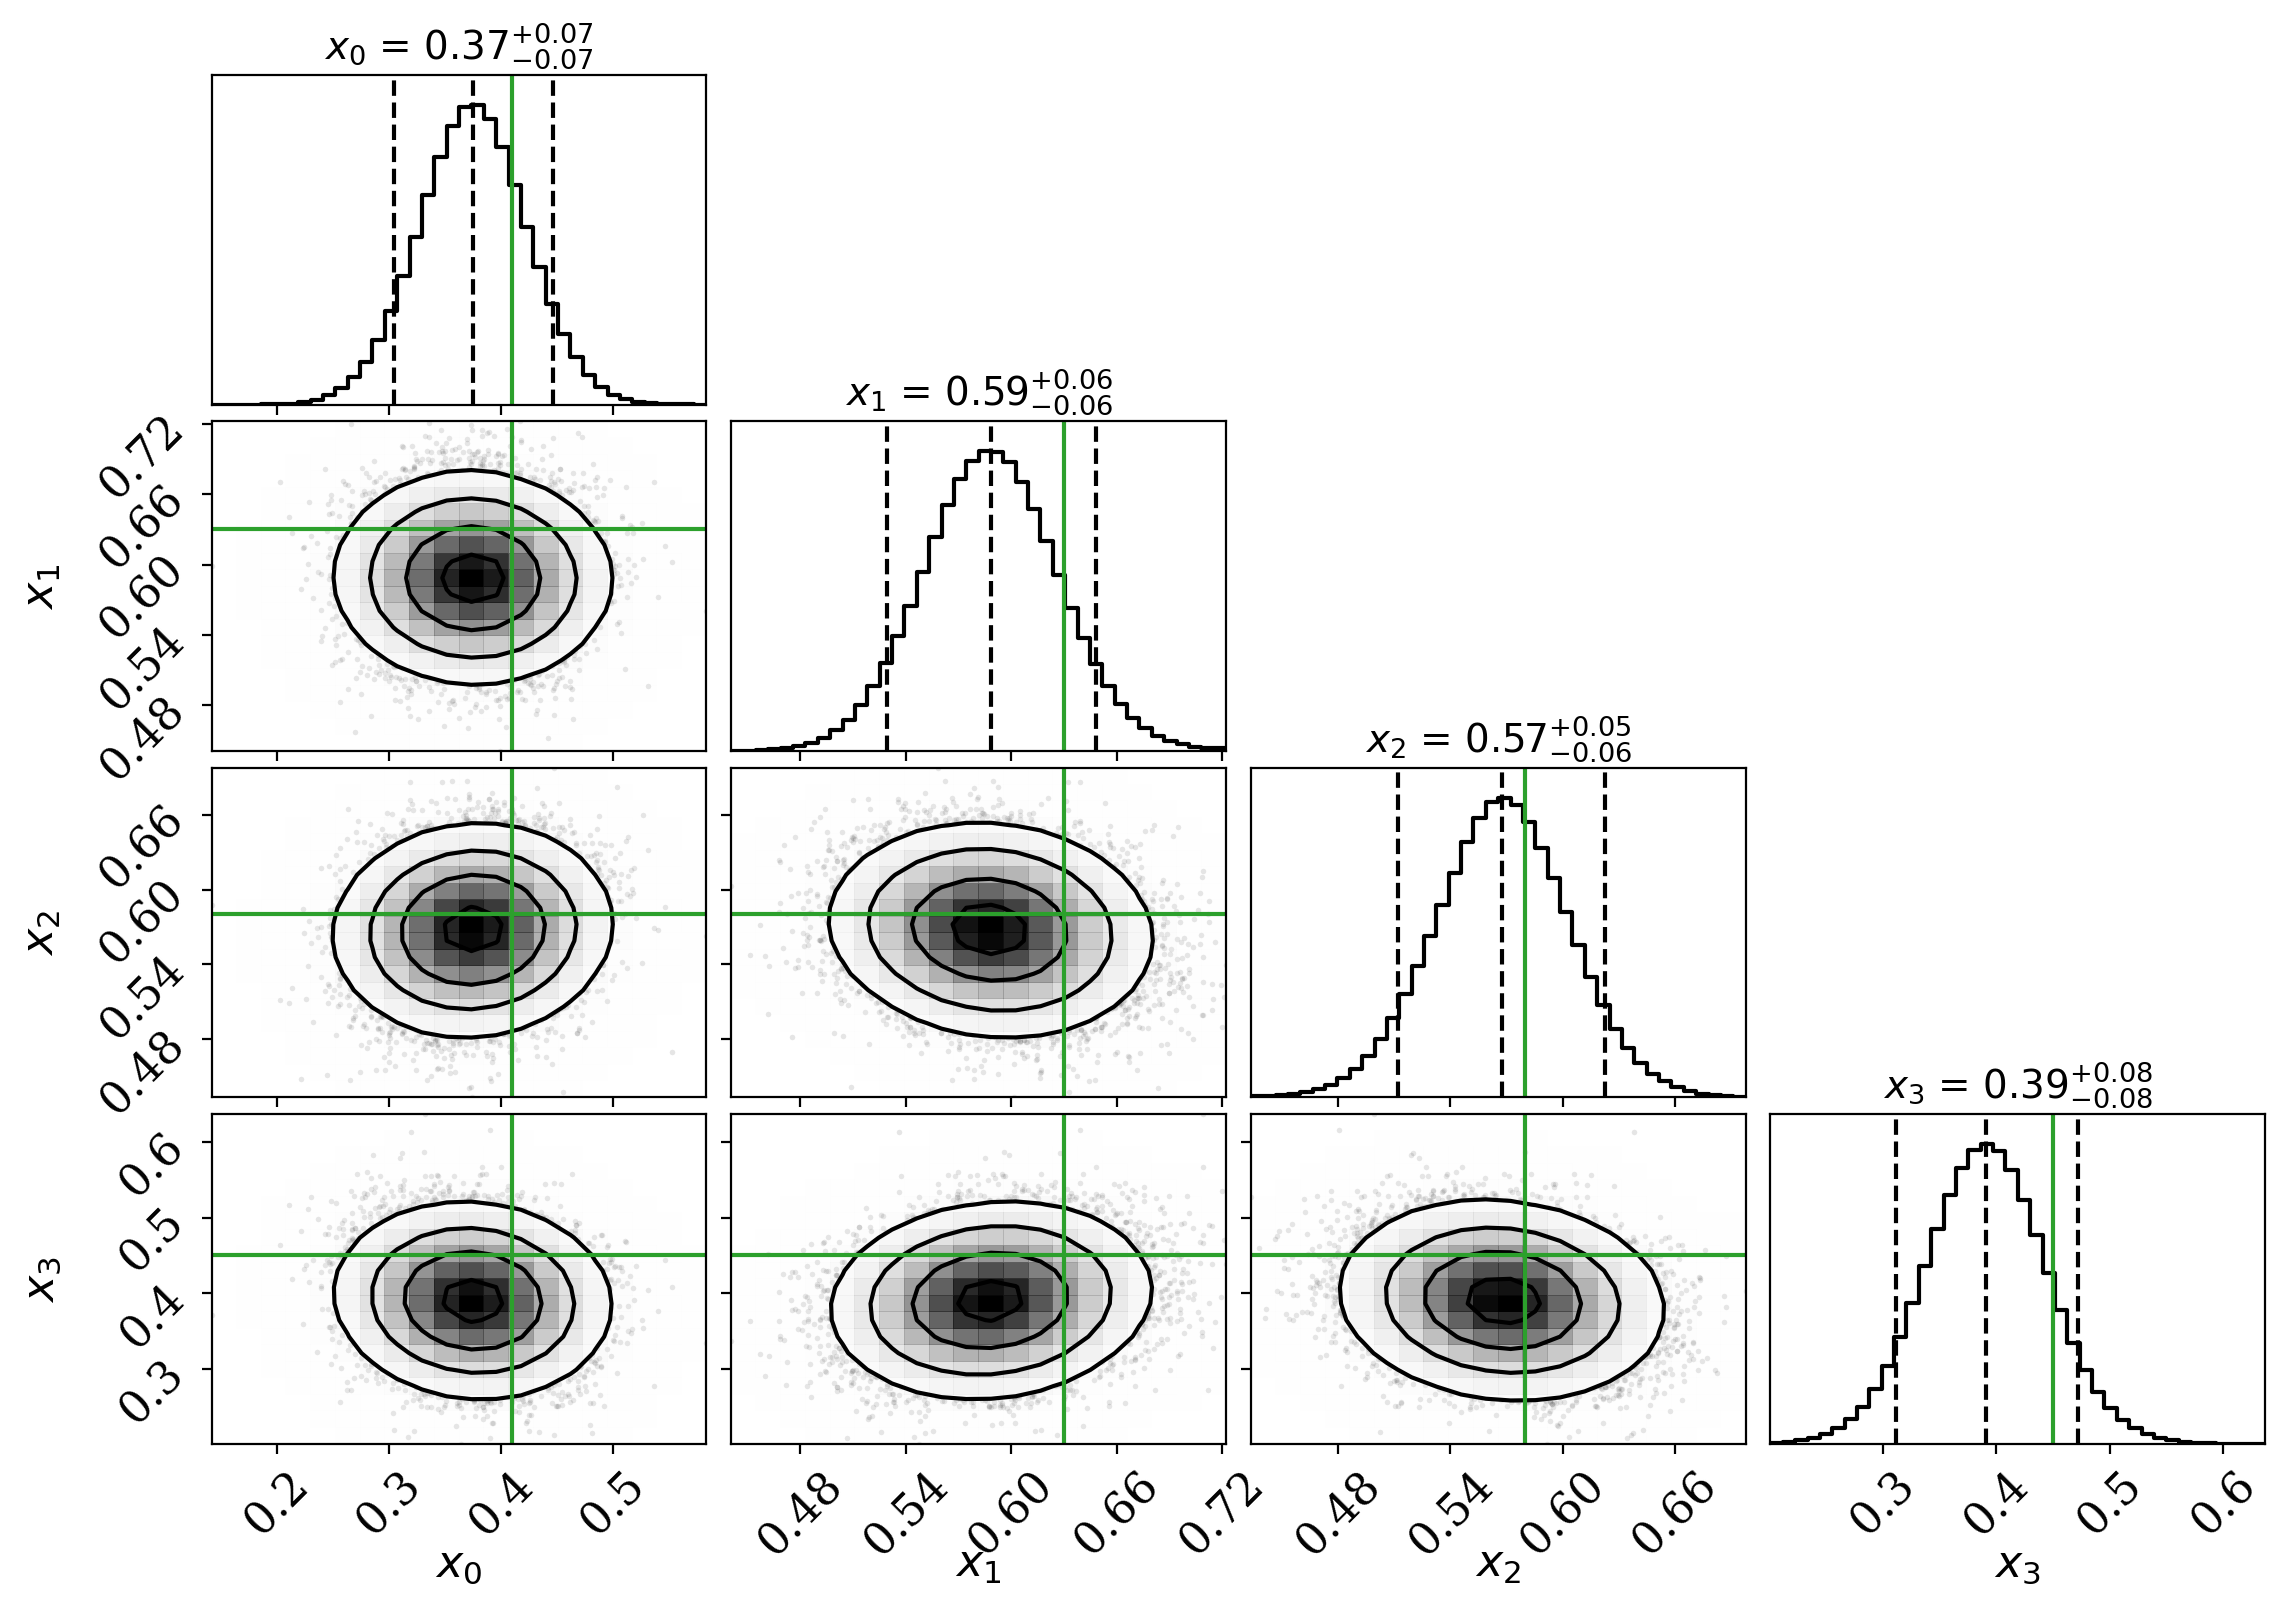

In [10]:
print(samples.shape)

print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))
fig = plt.figure(figsize=(12,8))

fig = corner.corner(samples,labels=["$x_{0}$".format(i) for i in range(ndim)],
    quantiles=[0.05, 0.5,0.95], # [0.16, 0.5,0.84]
    show_titles=True,
    title_kwargs={"fontsize": 14},
    fig=fig,hist_bin_factor=2.,smooth1d=2.,smooth=2.,truth=list[f_mean],truth_color='r'
)

corner.overplot_lines(fig,f_mean,color='C2')